In [1]:
from solvers import *
from ct import ct_astra
from projectors import *
import csv
import numpy as np
import matplotlib.pyplot as plt


c:\Users\ryand\OneDrive\Desktop\Hybrid-ABBA-GMRES-ABBA-LSQR\solvers.py:281: SyntaxWarning: invalid escape sequence '\A'
  print("\AB-lsqr is running")
c:\Users\ryand\OneDrive\Desktop\Hybrid-ABBA-GMRES-ABBA-LSQR\solvers.py:370: SyntaxWarning: invalid escape sequence '\B'
  print("\BA-lsqr is running")
c:\Users\ryand\OneDrive\Desktop\Hybrid-ABBA-GMRES-ABBA-LSQR\solvers.py:461: SyntaxWarning: invalid escape sequence '\B'
  print("\BA-lsqr is running")


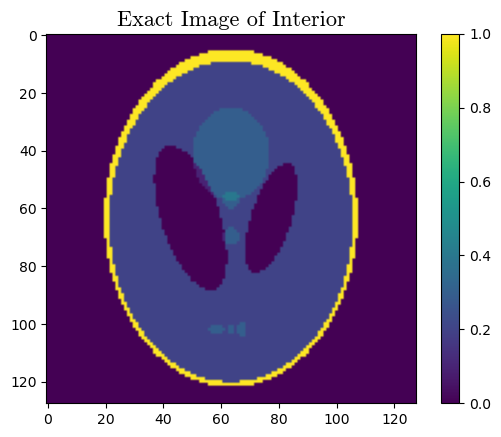

In [2]:
reader = csv.reader(open('X_128_shepplogan_rnl03.csv'), delimiter=",")
X = np.array(list(reader)).astype("float32")
plt.figure()
plt.imshow(X)
plt.title('Exact Image of Interior',fontname='cmr10',fontsize=16)
plt.colorbar()
plt.show()

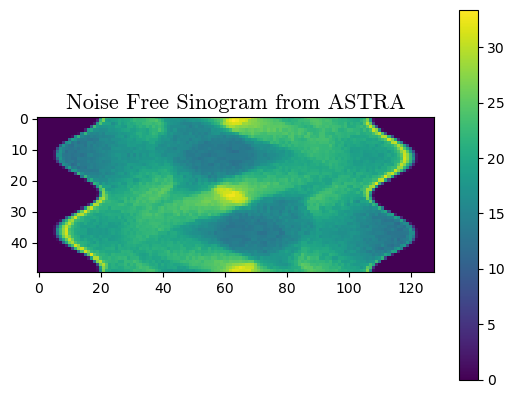

In [3]:
# CT setup
num_pixels      = np.shape(X)[0]    # Number of pixels in x/y direction (X needs to be square)
num_dets        = num_pixels        # Number of detector pixels
num_angles      = 50               # Number of projection angles
ang_start       = 0                 # Start angle in degress
ang_end         = 360               # End angle in degress
angles          = np.linspace(ang_start,ang_end,num_angles,dtype=int) / 180 * np.pi 
# %% ************************************ ASTRA ************************************
# Parameters for ASTRA
proj_model      = 'linear'          # The projection model: 'line', 'strip', or 'linear'
proj_geom       = 'fanflat'         # The projection geometry: 'parallel' or 'fanflat'
source_origin   = 1000              # Distance from source to origin/center
origin_det      = 0                 # Distance from origin/center to detector
det_width       = 1                 # Detector width
gpu             = True              # Construct unmatched normal equations: 'False' or 'True' 
ct = ct_astra(num_pixels,num_angles,num_dets,angles,proj_model,proj_geom,source_origin,origin_det,det_width,gpu)

# Create Sinogram
_, Bexact = astra.create_sino(X, ct.proj_id)
plt.figure()
plt.imshow(Bexact)
plt.title('Noise Free Sinogram from ASTRA',fontname='cmr10',fontsize=16)
plt.colorbar()
plt.show()

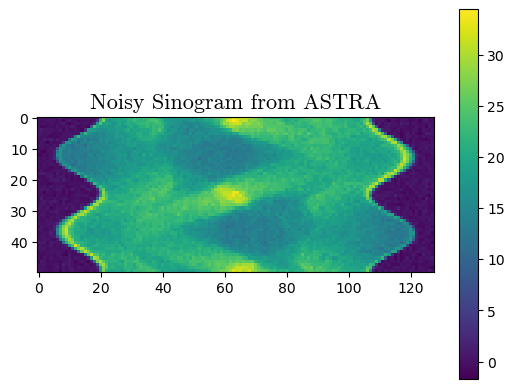

In [4]:
# Create noisy sinogram
rnl     = 0.03
e0      = np.random.normal(0.0, 1.0, ct.m)
e1      = e0/np.linalg.norm(e0)
bexact  = Bexact.reshape(-1)
e       = rnl*np.linalg.norm(bexact)*e1
b       = bexact + e
plt.figure()
plt.imshow(b.reshape(num_angles, 128))
plt.title('Noisy Sinogram from ASTRA',fontname='cmr10',fontsize=16)
plt.colorbar()
plt.show()

In [5]:
A       = fp_astra(ct)     # The forward projector
B       = bp_astra(ct)     # The back projector  

iter    = 100               # Maximum number of iterations

AB_X_lcurve, AB_R_lcurve= hybrid_AB_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles)
AB_X_gcv, AB_R_gcv= hybrid_AB_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles, regparam= 'gcv')

BA_X_lcurve, BA_R_lcurve= hybrid_BA_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles, regparam= 'lcurve')
BA_X_gcv, BA_R_gcv= hybrid_BA_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles, regparam= 'gcv')




Hybrid-AB-GMRES is running
Hybrid AB-GMRES execution time: 1.9014 seconds
| ID | Name                        | Serial | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | NVIDIA RTX A2000 Laptop GPU | [N/A]  | GPU-c9c3bf57-eb39-ac27-c375-52325de3e1f8 ||       52C |       29% |           6% ||       4096MB |       226MB |      3740MB || Disabled     | Disabled       |

Hybrid-AB-GMRES is running
Hybrid AB-GMRES execution time: 5.1300 seconds
| ID | Name                        | Serial | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------

<function matplotlib.pyplot.show(close=None, block=None)>

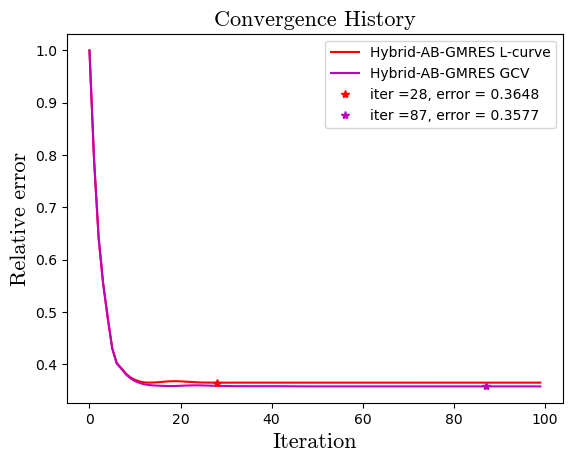

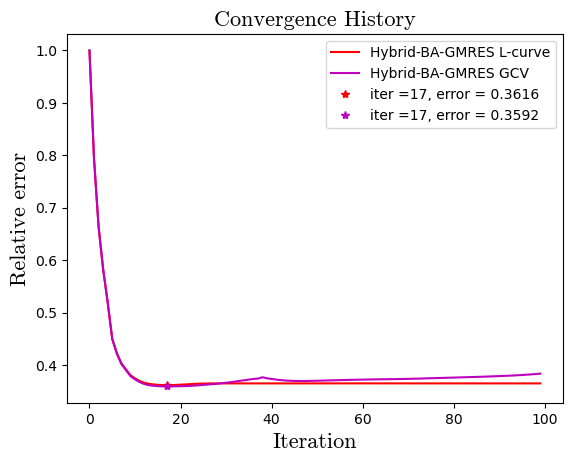

In [6]:
res_AB_lcurve = np.zeros((iter,1))
res_AB_gcv = np.zeros((iter,1))
res_BA_lcurve = np.zeros((iter,1))
res_BA_gcv = np.zeros((iter,1))

for i in range(0,iter):
    res_AB_lcurve[i] = np.linalg.norm(X.reshape(-1) - AB_X_lcurve[:,i])/np.linalg.norm(X.reshape(-1))
    res_AB_gcv[i] = np.linalg.norm(X.reshape(-1) - AB_X_gcv[:,i])/np.linalg.norm(X.reshape(-1))
    res_BA_lcurve[i] = np.linalg.norm(X.reshape(-1) - BA_X_lcurve[:,i])/np.linalg.norm(X.reshape(-1))
    res_BA_gcv[i] = np.linalg.norm(X.reshape(-1) - BA_X_gcv[:,i])/np.linalg.norm(X.reshape(-1))

val_AB_lcurve = np.min(res_AB_lcurve)
val_AB_gcv = np.min(res_AB_gcv)
val_BA_lcurve = np.min(res_BA_lcurve)
val_BA_gcv = np.min(res_BA_gcv)


idx_AB_lcurve = np.argmin(res_AB_lcurve)
idx_AB_gcv = np.argmin(res_AB_gcv)
idx_BA_lcurve = np.argmin(res_BA_lcurve)
idx_BA_gcv = np.argmin(res_BA_gcv)

# Plotting
plt.figure()
plt.plot(range(0,iter),res_AB_lcurve,'r-')
plt.plot(range(0,iter),res_AB_gcv,'m-')
plt.plot(idx_AB_lcurve,val_AB_lcurve,'r*')
plt.plot(idx_AB_gcv,val_AB_gcv,'m*')
plt.title('Convergence History',fontname='cmr10',fontsize=16)
plt.xlabel('Iteration',fontname='cmr10',fontsize=16)
plt.ylabel('Relative error',fontname='cmr10',fontsize=16)
plt.legend(['Hybrid-AB-GMRES L-curve', 'Hybrid-AB-GMRES GCV',
            'iter ='+str(idx_AB_lcurve)+', error = '+str(round(val_AB_lcurve,4)),
            'iter ='+str(idx_AB_gcv)+', error = '+str(round(val_AB_gcv,4))])
plt.show

plt.figure()
plt.plot(range(0,iter),res_BA_lcurve,'r-')
plt.plot(range(0,iter),res_BA_gcv,'m-')
plt.plot(idx_BA_lcurve,val_BA_lcurve,'r*')
plt.plot(idx_BA_gcv,val_BA_gcv,'m*')
plt.title('Convergence History',fontname='cmr10',fontsize=16)
plt.xlabel('Iteration',fontname='cmr10',fontsize=16)
plt.ylabel('Relative error',fontname='cmr10',fontsize=16)
plt.legend(['Hybrid-BA-GMRES L-curve', 'Hybrid-BA-GMRES GCV',
            'iter ='+str(idx_BA_lcurve)+', error = '+str(round(val_BA_lcurve,4)),
            'iter ='+str(idx_BA_gcv)+', error = '+str(round(val_BA_gcv,4))])
plt.show

In [7]:
AB_X_lcurve_r, AB_R_lcurve_r= hybrid_AB_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles, regparam='lcurve', p = 10)
AB_X_gcv_r, AB_R_gcv_r= hybrid_AB_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles, regparam= 'gcv', p = 10)

BA_X_lcurve_r, BA_R_lcurve_r= hybrid_BA_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles, regparam= 'lcurve', p = 10)
BA_X_gcv_r, BA_R_gcv_r= hybrid_BA_GMRES(A,B,b,iter,ct.m, ct.n, ct.num_angles, regparam= 'gcv', p = 10)



Hybrid-AB-GMRES is running
Hybrid AB-GMRES execution time: 1.2302 seconds
| ID | Name                        | Serial | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | NVIDIA RTX A2000 Laptop GPU | [N/A]  | GPU-c9c3bf57-eb39-ac27-c375-52325de3e1f8 ||       69C |       39% |          13% ||       4096MB |       515MB |      3451MB || Disabled     | Disabled       |

Hybrid-AB-GMRES is running
Hybrid AB-GMRES execution time: 2.4140 seconds
| ID | Name                        | Serial | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------

<function matplotlib.pyplot.show(close=None, block=None)>

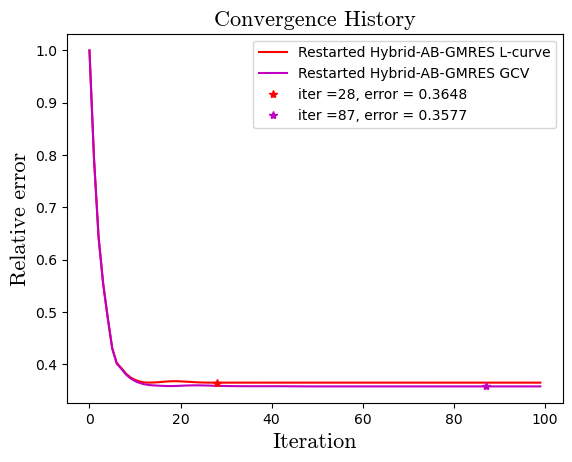

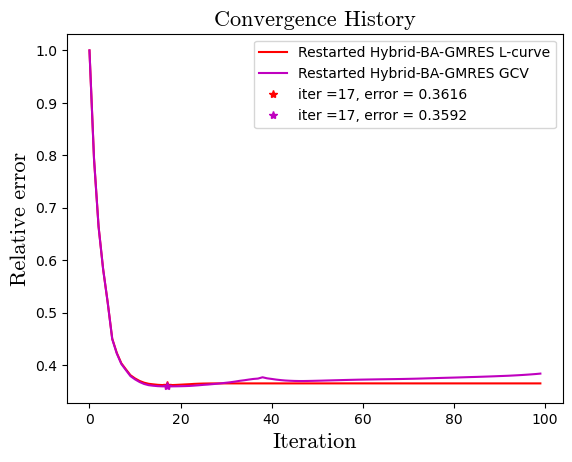

In [8]:
res_AB_lcurve_r = np.zeros((iter,1))
res_AB_gcv_r = np.zeros((iter,1))
res_BA_lcurve_r = np.zeros((iter,1))
res_BA_gcv_r = np.zeros((iter,1))

for i in range(0,iter):
    res_AB_lcurve_r[i] = np.linalg.norm(X.reshape(-1) - AB_X_lcurve[:,i])/np.linalg.norm(X.reshape(-1))
    res_AB_gcv_r[i] = np.linalg.norm(X.reshape(-1) - AB_X_gcv[:,i])/np.linalg.norm(X.reshape(-1))
    res_BA_lcurve_r[i] = np.linalg.norm(X.reshape(-1) - BA_X_lcurve[:,i])/np.linalg.norm(X.reshape(-1))
    res_BA_gcv_r[i] = np.linalg.norm(X.reshape(-1) - BA_X_gcv[:,i])/np.linalg.norm(X.reshape(-1))

val_AB_lcurve_r = np.min(res_AB_lcurve_r)
val_AB_gcv_r = np.min(res_AB_gcv_r)
val_BA_lcurve_r = np.min(res_BA_lcurve_r)
val_BA_gcv_r = np.min(res_BA_gcv_r)


idx_AB_lcurve_r = np.argmin(res_AB_lcurve_r)
idx_AB_gcv_r = np.argmin(res_AB_gcv_r)
idx_BA_lcurve_r = np.argmin(res_BA_lcurve_r)
idx_BA_gcv_r = np.argmin(res_BA_gcv_r)

# Plotting
plt.figure()
plt.plot(range(0,iter),res_AB_lcurve_r,'r-')
plt.plot(range(0,iter),res_AB_gcv_r,'m-')
plt.plot(idx_AB_lcurve_r,val_AB_lcurve_r,'r*')
plt.plot(idx_AB_gcv_r,val_AB_gcv_r,'m*')
plt.title('Convergence History',fontname='cmr10',fontsize=16)
plt.xlabel('Iteration',fontname='cmr10',fontsize=16)
plt.ylabel('Relative error',fontname='cmr10',fontsize=16)
plt.legend(['Restarted Hybrid-AB-GMRES L-curve', 'Restarted Hybrid-AB-GMRES GCV',
            'iter ='+str(idx_AB_lcurve_r)+', error = '+str(round(val_AB_lcurve_r,4)),
            'iter ='+str(idx_AB_gcv_r)+', error = '+str(round(val_AB_gcv_r,4))])
plt.show

plt.figure()
plt.plot(range(0,iter),res_BA_lcurve_r,'r-')
plt.plot(range(0,iter),res_BA_gcv_r,'m-')
plt.plot(idx_BA_lcurve_r,val_BA_lcurve_r,'r*')
plt.plot(idx_BA_gcv_r,val_BA_gcv_r,'m*')
plt.title('Convergence History',fontname='cmr10',fontsize=16)
plt.xlabel('Iteration',fontname='cmr10',fontsize=16)
plt.ylabel('Relative error',fontname='cmr10',fontsize=16)
plt.legend(['Restarted Hybrid-BA-GMRES L-curve', 'Restarted Hybrid-BA-GMRES GCV',
            'iter ='+str(idx_BA_lcurve_r)+', error = '+str(round(val_BA_lcurve_r,4)),
            'iter ='+str(idx_BA_gcv_r)+', error = '+str(round(val_BA_gcv_r,4))])
plt.show

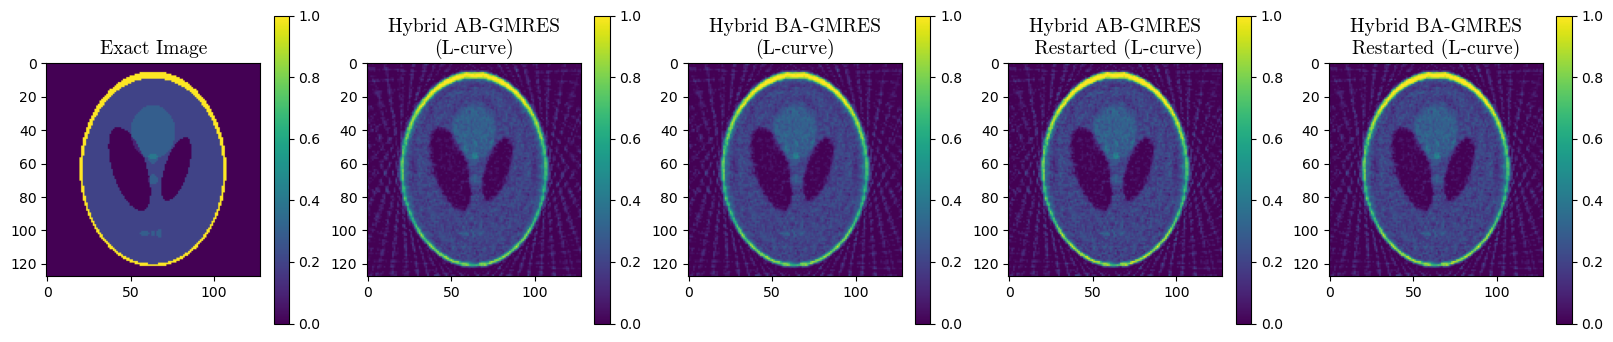

In [9]:
xmin = np.min(X,)
xmax = np.max(X,)
fig, axs = plt.subplots(1,5, figsize=(20,4))
im0 = axs[0].imshow(X,vmin=xmin,vmax=xmax)
axs[0].set_title("Exact Image",fontname='cmr10',fontsize=14)
plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(AB_X_lcurve[:,idx_AB_lcurve].reshape(num_pixels,num_pixels),vmin=xmin,vmax=xmax)
axs[1].set_title("Hybrid AB-GMRES\n(L-curve)",fontname='cmr10',fontsize=14)
plt.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(BA_X_lcurve[:,idx_BA_lcurve].reshape(num_pixels,num_pixels),vmin=xmin,vmax=xmax)
axs[2].set_title("Hybrid BA-GMRES\n(L-curve)",fontname='cmr10',fontsize=14)
plt.colorbar(im2, ax=axs[2])
im3 = axs[3].imshow(AB_X_lcurve_r[:,idx_AB_lcurve_r].reshape(num_pixels,num_pixels),vmin=xmin,vmax=xmax)
axs[3].set_title("Hybrid AB-GMRES\n Restarted (L-curve)",fontname='cmr10',fontsize=14)
plt.colorbar(im3, ax=axs[3])
im4 = axs[4].imshow(BA_X_lcurve_r[:,idx_BA_lcurve_r].reshape(num_pixels,num_pixels),vmin=xmin,vmax=xmax)
axs[4].set_title("Hybrid BA-GMRES\nRestarted (L-curve)",fontname='cmr10',fontsize=14)
plt.colorbar(im4, ax=axs[4])

plt.show()


In [10]:
regparam = 'lcurve'
p = 10

X_BA, R_BA = hybrid_BA_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, p = p, regparam=regparam)
X_AB, R_AB = hybrid_AB_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, p = p, regparam=regparam)

# Using DP as the stopping rule
# -------------------------------
stop_rule   = 'DP'          # The stopping criteria, DP = discrepancy principal
delta         = np.std(e)     # The noise level, when using DP as stopping criteria
X_BA_dp, R_BA_dp = hybrid_BA_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, stop_rule = stop_rule, delta = delta, p = p, regparam=regparam)
X_AB_dp, R_AB_dp = hybrid_AB_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, stop_rule = stop_rule, delta = delta, p = p, regparam=regparam)

# Using NCP as the stopping rule
# -------------------------------
stop_rule   = 'NCP'         # The stopping criteria, NCP = normalized cumulative periodogram
X_BA_ncp, R_BA_ncp = hybrid_BA_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, stop_rule = stop_rule, p = p, regparam=regparam)
X_AB_ncp, R_AB_ncp = hybrid_AB_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, stop_rule = stop_rule, p = p, regparam=regparam)


# Using RNS as the stopping rule
# -------------------------------

stop_rule   = 'RNS'         # The stopping criteria, RNS = Residual Norm Stagnation
X_BA_rns, R_BA_rns = hybrid_BA_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, stop_rule = stop_rule, p = p, regparam=regparam)
X_AB_rns, R_AB_rns = hybrid_AB_GMRES(A, B, b, iter, ct.m, ct.n, ct.num_angles, stop_rule = stop_rule, p = p, regparam=regparam)



Hybrid-BA-GMRES is running
Hybrid BA-GMRES execution time: 1.2410 seconds
| ID | Name                        | Serial | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  0 | NVIDIA RTX A2000 Laptop GPU | [N/A]  | GPU-c9c3bf57-eb39-ac27-c375-52325de3e1f8 ||       69C |       32% |          14% ||       4096MB |       561MB |      3405MB || Disabled     | Disabled       |

Hybrid-AB-GMRES is running
Hybrid AB-GMRES execution time: 0.9513 seconds
| ID | Name                        | Serial | UUID                                     || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------

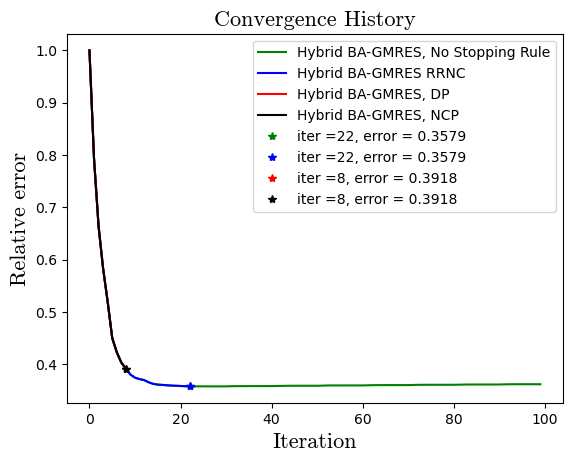

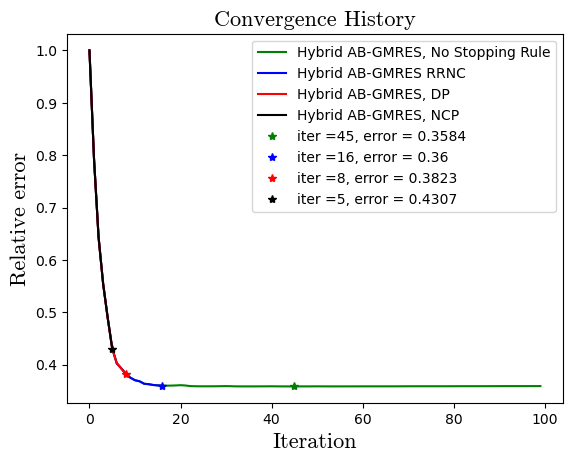

In [11]:
# Computing the relative error between the solutions x_i and the true solution
res = np.zeros((iter, 1))
for i in range(0, iter):
    res[i] = np.linalg.norm(X.reshape(-1) - X_BA[:,i])/np.linalg.norm(X.reshape(-1))
val = np.min(res)
idx = np.argmin(res)

# Errors of DP
iter_dp = np.shape(X_BA_dp)[1] - 1
res_dp = np.zeros((iter_dp,1))
for i in range(0,iter_dp):
    res_dp[i] = np.linalg.norm(X.reshape(-1) - X_BA_dp[:,i])/np.linalg.norm(X.reshape(-1))
val_dp = np.min(res_dp)
idx_dp = np.argmin(res_dp)

# Errors of NCP
iter_ncp = np.shape(X_BA_ncp)[1] - 1
res_ncp = np.zeros((iter_ncp,1))
for i in range(0,iter_ncp):
    res_ncp[i] = np.linalg.norm(X.reshape(-1) - X_BA_ncp[:,i])/np.linalg.norm(X.reshape(-1))
val_ncp = np.min(res_ncp)
idx_ncp = np.argmin(res_ncp)

# Errors of rns
iter_rns = np.shape(X_BA_rns)[1] - 1
res_rns = np.zeros((iter_rns,1))
for i in range(0,iter_rns):
    res_rns[i] = np.linalg.norm(X.reshape(-1) - X_BA_rns[:,i])/np.linalg.norm(X.reshape(-1))
val_rns = np.min(res_rns)
idx_rns = np.argmin(res_rns)

# Plotting
plt.figure()
plt.plot(range(0,iter),res,'g-')
plt.plot(range(0,iter_rns),res_rns,'b-')
plt.plot(range(0,iter_dp),res_dp,'r-')
plt.plot(range(0,iter_ncp),res_ncp,'k-')

plt.plot(idx,val,'g*')
plt.plot(idx_rns,val_rns,'b*')
plt.plot(idx_dp,val_dp,'r*')
plt.plot(idx_ncp,val_ncp,'k*')

plt.title('Convergence History',fontname='cmr10',fontsize=16)
plt.xlabel('Iteration',fontname='cmr10',fontsize=16)
plt.ylabel('Relative error',fontname='cmr10',fontsize=16)
plt.legend(['Hybrid BA-GMRES, No Stopping Rule', 'Hybrid BA-GMRES RRNC','Hybrid BA-GMRES, DP','Hybrid BA-GMRES, NCP',
            'iter ='+str(idx)+', error = '+str(round(val,4)),
            'iter ='+str(idx_rns)+', error = '+str(round(val_rns,4)),
            'iter ='+str(idx_dp)+', error = '+str(round(val_dp,4)),
            'iter ='+str(idx_ncp)+', error = '+str(round(val_ncp,4))])
plt.show()

res = np.zeros((iter, 1))
for i in range(0, iter):
    res[i] = np.linalg.norm(X.reshape(-1) - X_AB[:,i])/np.linalg.norm(X.reshape(-1))
val = np.min(res)
idx = np.argmin(res)

# Errors of DP
iter_dp = np.shape(X_AB_dp)[1] - 1
res_dp = np.zeros((iter_dp,1))
for i in range(0,iter_dp):
    res_dp[i] = np.linalg.norm(X.reshape(-1) - X_AB_dp[:,i])/np.linalg.norm(X.reshape(-1))
val_dp = np.min(res_dp)
idx_dp = np.argmin(res_dp)

# Errors of NCP
iter_ncp = np.shape(X_AB_ncp)[1] - 1
res_ncp = np.zeros((iter_ncp,1))
for i in range(0,iter_ncp):
    res_ncp[i] = np.linalg.norm(X.reshape(-1) - X_AB_ncp[:,i])/np.linalg.norm(X.reshape(-1))
val_ncp = np.min(res_ncp)
idx_ncp = np.argmin(res_ncp)

# Errors of rns
iter_rns = np.shape(X_AB_rns)[1] - 1
res_rns = np.zeros((iter_rns,1))
for i in range(0,iter_rns):
    res_rns[i] = np.linalg.norm(X.reshape(-1) - X_AB_rns[:,i])/np.linalg.norm(X.reshape(-1))
val_rns = np.min(res_rns)
idx_rns = np.argmin(res_rns)

# Plotting
plt.figure()
plt.plot(range(0,iter),res,'g-')
plt.plot(range(0,iter_rns),res_rns,'b-')
plt.plot(range(0,iter_dp),res_dp,'r-')
plt.plot(range(0,iter_ncp),res_ncp,'k-')

plt.plot(idx,val,'g*')
plt.plot(idx_rns,val_rns,'b*')
plt.plot(idx_dp,val_dp,'r*')
plt.plot(idx_ncp,val_ncp,'k*')

plt.title('Convergence History',fontname='cmr10',fontsize=16)
plt.xlabel('Iteration',fontname='cmr10',fontsize=16)
plt.ylabel('Relative error',fontname='cmr10',fontsize=16)
plt.legend(['Hybrid AB-GMRES, No Stopping Rule', 'Hybrid AB-GMRES RRNC','Hybrid AB-GMRES, DP','Hybrid AB-GMRES, NCP',
            'iter ='+str(idx)+', error = '+str(round(val,4)),
            'iter ='+str(idx_rns)+', error = '+str(round(val_rns,4)),
            'iter ='+str(idx_dp)+', error = '+str(round(val_dp,4)),
            'iter ='+str(idx_ncp)+', error = '+str(round(val_ncp,4))])
plt.show()

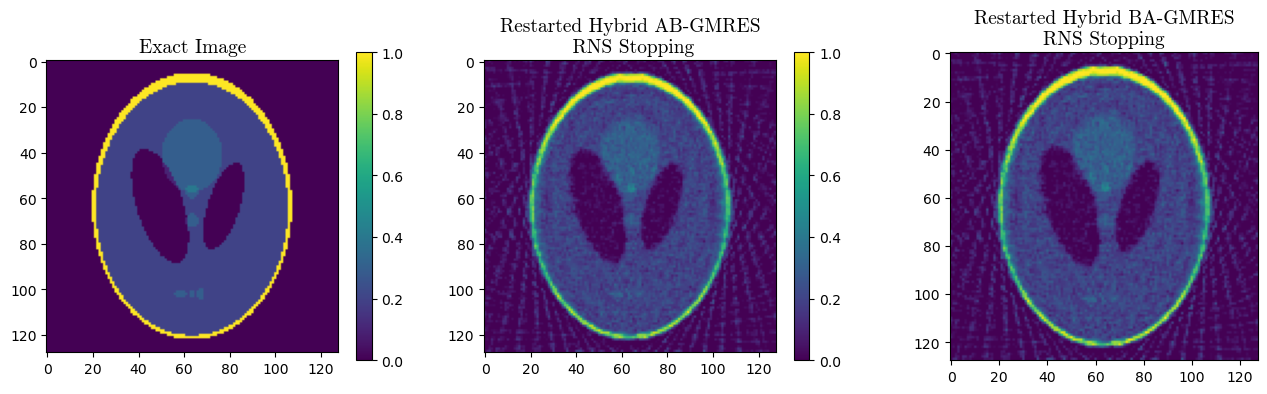

In [14]:
xmin = np.min(X,)
xmax = np.max(X,)
fig, axs = plt.subplots(1,3, figsize=(16,4))
im0 = axs[0].imshow(X,vmin=xmin,vmax=xmax)
axs[0].set_title("Exact Image",fontname='cmr10',fontsize=14)
plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(X_AB_rns[:,-1].reshape(num_pixels,num_pixels),vmin=xmin,vmax=xmax)
axs[1].set_title("Restarted Hybrid AB-GMRES\n RNS Stopping",fontname='cmr10',fontsize=14)
plt.colorbar(im1, ax=axs[1])
im2 = axs[2].imshow(X_BA_rns[:,-1].reshape(num_pixels,num_pixels),vmin=xmin,vmax=xmax)
axs[2].set_title("Restarted Hybrid BA-GMRES\nRNS Stopping",fontname='cmr10',fontsize=14)

plt.show()
